# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
%pip install pandas-datareader
%pip install git+https://github.com/elben10/pydst
%pip install matplotlib-venn

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

import pandas_datareader 
import pydst 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# user written modules
import dataproject

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/elben10/pydst to /private/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/pip-req-build-2a72wddj
  Running command git clone --filter=blob:none --quiet https://github.com/elben10/pydst /private/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/pip-req-build-2a72wddj
  Resolved https://github.com/elben10/pydst to commit bb347560a1b3c17684fda072c829658da38f5a72
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Read and clean data

Import your data, either through an API or manually, and load it. 

#Statistikbanken

In [19]:
# Loading the Data from statistikbanken
filename = 'Ejendom.xlsx'
pd.read_excel(filename).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551.0,565.0,622.0,656.0,753.0,806.0,...,1883.0,1955.0,2082.0,2122.0,2209.0,2257.0,2335.0,2477.0,2639.0,2464.0
3,NaN,NaN,NaN,Region Hovedstaden,777.0,789.0,876.0,935.0,1088.0,1195.0,...,2965.0,3075.0,3310.0,3465.0,3623.0,3754.0,3873.0,4231.0,4723.0,4471.0
4,NaN,NaN,NaN,Landsdel Byen København,767.0,785.0,856.0,917.0,1063.0,1169.0,...,3535.0,3775.0,4129.0,4441.0,4725.0,4938.0,5128.0,5708.0,6198.0,6146.0


In [20]:
# Now we are dropping rows
prop = pd.read_excel(filename, skiprows=2)
prop.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551,565,622,656,753,806,...,1883,1955,2082,2122,2209,2257,2335,2477,2639,2464
1,NaN,NaN,NaN,Region Hovedstaden,777,789,876,935,1088,1195,...,2965,3075,3310,3465,3623,3754,3873,4231,4723,4471
2,NaN,NaN,NaN,Landsdel Byen København,767,785,856,917,1063,1169,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,NaN,NaN,NaN,Landsdel Københavns omegn,836,844,955,1029,1204,1321,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,NaN,NaN,NaN,Landsdel Nordsjælland,797,810,901,965,1126,1226,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153


In [21]:
# Now we drop the first two columns
del prop['Unnamed: 0'], prop['Unnamed: 1'], prop['Unnamed: 2']
prop.head(5)

,Unnamed: 3,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Hele landet,551,565,622,656,753,806,884,955,1047,...,1883,1955,2082,2122,2209,2257,2335,2477,2639,2464
1,Region Hovedstaden,777,789,876,935,1088,1195,1338,1485,1631,...,2965,3075,3310,3465,3623,3754,3873,4231,4723,4471
2,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153


In [22]:
# Now we rename the variable 'Unnamed: 3' 
prop.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'prop{i}' 
prop.rename(columns = col_dict, inplace=True)
prop.head(10)

,County,prop1992,prop1993,prop1994,prop1995,prop1996,prop1997,prop1998,prop1999,prop2000,...,prop2013,prop2014,prop2015,prop2016,prop2017,prop2018,prop2019,prop2020,prop2021,prop2022
0,Hele landet,551,565,622,656,753,806,884,955,1047,...,1883,1955,2082,2122,2209,2257,2335,2477,2639,2464
1,Region Hovedstaden,777,789,876,935,1088,1195,1338,1485,1631,...,2965,3075,3310,3465,3623,3754,3873,4231,4723,4471
2,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153
5,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,819,798,811,897,987,1007,1044,1135,1314,1260
6,Region Sjælland,509,529,576,608,686,740,809,874,966,...,1562,1583,1740,1780,1848,1942,1996,2090,2272,2186
7,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,2253,2304,2491,2685,2755,2934,3052,3252,3681,3684
8,Landsdel Vest- og Sydsjælland,445,457,490,517,567,616,675,732,795,...,1173,1158,1292,1309,1377,1459,1495,1533,1702,1659
9,Region Syddanmark,484,496,544,571,653,696,767,812,856,...,1362,1407,1487,1495,1566,1617,1688,1722,1858,1812


In [23]:
# We are only interesetd in the Countys so we drop the regions and the whole country
I = prop.County.str.contains('Region')
I |= prop.County.str.contains('Hele landet')
prop.loc[I, :]
prop = prop.loc[I == False]
prop.head(5)

,County,prop1992,prop1993,prop1994,prop1995,prop1996,prop1997,prop1998,prop1999,prop2000,...,prop2013,prop2014,prop2015,prop2016,prop2017,prop2018,prop2019,prop2020,prop2021,prop2022
2,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153
5,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,819,798,811,897,987,1007,1044,1135,1314,1260
7,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,2253,2304,2491,2685,2755,2934,3052,3252,3681,3684


In [24]:
# We reset the index 
prop.reset_index(inplace = True, drop = True) # Drop old index too
prop.iloc[0:5,:]

,County,prop1992,prop1993,prop1994,prop1995,prop1996,prop1997,prop1998,prop1999,prop2000,...,prop2013,prop2014,prop2015,prop2016,prop2017,prop2018,prop2019,prop2020,prop2021,prop2022
0,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
1,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
2,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153
3,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,819,798,811,897,987,1007,1044,1135,1314,1260
4,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,2253,2304,2491,2685,2755,2934,3052,3252,3681,3684


In [45]:
# We convert to dataset into 
prop_long = prop.melt(id_vars=['County'], var_name = 'Year', value_name='Sales')
prop_long.head(10) 

,County,Year,Sales
0,Landsdel Byen København,prop1992,767
1,Landsdel Københavns omegn,prop1992,836
2,Landsdel Nordsjælland,prop1992,797
3,Landsdel Bornholm,prop1992,335
4,Landsdel Østsjælland,prop1992,704
5,Landsdel Vest- og Sydsjælland,prop1992,445
6,Landsdel Fyn,prop1992,470
7,Landsdel Sydjylland,prop1992,494
8,Landsdel Østjylland,prop1992,557
9,Landsdel Vestjylland,prop1992,471


In [ ]:
prop_long['properties_demean'] = prop_long.Properties - prop_long.Properties.mean()
prop_long.head()

Ejerlejligheder

In [7]:
# Loading the Data from statistikbanken
filename1 = 'Ejerlejligheder.xlsx'
pd.read_excel(filename1).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),"Ejerlejligheder, i alt",Hele landet,421.0,419.0,452.0,474.0,514.0,536.0,...,1845.0,1945.0,2063.0,2156.0,2369.0,2470.0,2570.0,2800.0,3005.0,2847.0
3,NaN,NaN,NaN,Region Hovedstaden,446.0,443.0,482.0,502.0,538.0,557.0,...,2166.0,2236.0,2351.0,2511.0,2813.0,2958.0,3066.0,3351.0,3664.0,3520.0
4,NaN,NaN,NaN,Landsdel Byen København,421.0,417.0,453.0,475.0,510.0,529.0,...,2341.0,2411.0,2570.0,2798.0,3182.0,3355.0,3449.0,3730.0,4174.0,4026.0


In [8]:
# Now we are dropping rows
ap = pd.read_excel(filename1, skiprows=2)
ap.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),"Ejerlejligheder, i alt",Hele landet,421,419,452,474,514,536,...,1845,1945,2063,2156,2369,2470,2570,2800,3005,2847
1,NaN,NaN,NaN,Region Hovedstaden,446,443,482,502,538,557,...,2166,2236,2351,2511,2813,2958,3066,3351,3664,3520
2,NaN,NaN,NaN,Landsdel Byen København,421,417,453,475,510,529,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
3,NaN,NaN,NaN,Landsdel Københavns omegn,474,472,506,524,569,582,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
4,NaN,NaN,NaN,Landsdel Nordsjælland,504,506,564,576,615,643,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439


In [9]:
# Now we drop the first three columns
del ap['Unnamed: 0'], ap['Unnamed: 1'], ap['Unnamed: 2']
ap.head(5)

,Unnamed: 3,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Hele landet,421,419,452,474,514,536,631,716,810,...,1845,1945,2063,2156,2369,2470,2570,2800,3005,2847
1,Region Hovedstaden,446,443,482,502,538,557,674,789,906,...,2166,2236,2351,2511,2813,2958,3066,3351,3664,3520
2,Landsdel Byen København,421,417,453,475,510,529,668,808,929,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
3,Landsdel Københavns omegn,474,472,506,524,569,582,658,728,842,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
4,Landsdel Nordsjælland,504,506,564,576,615,643,742,829,930,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439


In [10]:
# Now we rename the variable 'Unnamed: 3' 
ap.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'ap{i}' 
ap.rename(columns = col_dict, inplace=True)
ap.head(10)

,County,ap1992,ap1993,ap1994,ap1995,ap1996,ap1997,ap1998,ap1999,ap2000,...,ap2013,ap2014,ap2015,ap2016,ap2017,ap2018,ap2019,ap2020,ap2021,ap2022
0,Hele landet,421,419,452,474,514,536,631,716,810,...,1845,1945,2063,2156,2369,2470,2570,2800,3005,2847
1,Region Hovedstaden,446,443,482,502,538,557,674,789,906,...,2166,2236,2351,2511,2813,2958,3066,3351,3664,3520
2,Landsdel Byen København,421,417,453,475,510,529,668,808,929,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
3,Landsdel Københavns omegn,474,472,506,524,569,582,658,728,842,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
4,Landsdel Nordsjælland,504,506,564,576,615,643,742,829,930,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
5,Landsdel Bornholm,377,334,349,443,410,350,428,371,581,...,607,679,700,875,898,657,809,895,1274,948
6,Region Sjælland,388,390,421,442,487,490,539,584,660,...,1180,1205,1326,1404,1432,1482,1582,1729,1845,1734
7,Landsdel Østsjælland,466,466,513,524,578,622,690,790,893,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383
8,Landsdel Vest- og Sydsjælland,338,331,355,373,396,388,426,445,514,...,906,958,999,1058,1076,1087,1133,1179,1268,1259
9,Region Syddanmark,357,349,373,397,435,462,518,548,582,...,1115,1139,1268,1256,1328,1465,1538,1555,1633,1614


In [12]:
# We are only interesetd in the Countys so we drop the regions and the whole country
I = ap.County.str.contains('Region')
I |= ap.County.str.contains('Hele landet')
ap.loc[I, :]
ap = ap.loc[I == False]
ap.head(5)

,County,ap1992,ap1993,ap1994,ap1995,ap1996,ap1997,ap1998,ap1999,ap2000,...,ap2013,ap2014,ap2015,ap2016,ap2017,ap2018,ap2019,ap2020,ap2021,ap2022
2,Landsdel Byen København,421,417,453,475,510,529,668,808,929,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
3,Landsdel Københavns omegn,474,472,506,524,569,582,658,728,842,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
4,Landsdel Nordsjælland,504,506,564,576,615,643,742,829,930,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
5,Landsdel Bornholm,377,334,349,443,410,350,428,371,581,...,607,679,700,875,898,657,809,895,1274,948
7,Landsdel Østsjælland,466,466,513,524,578,622,690,790,893,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383


In [14]:
# We reset the index 
ap.reset_index(inplace = True, drop = True) # Drop old index too
ap.iloc[0:5,:]

,County,ap1992,ap1993,ap1994,ap1995,ap1996,ap1997,ap1998,ap1999,ap2000,...,ap2013,ap2014,ap2015,ap2016,ap2017,ap2018,ap2019,ap2020,ap2021,ap2022
0,Landsdel Byen København,421,417,453,475,510,529,668,808,929,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
1,Landsdel Københavns omegn,474,472,506,524,569,582,658,728,842,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
2,Landsdel Nordsjælland,504,506,564,576,615,643,742,829,930,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
3,Landsdel Bornholm,377,334,349,443,410,350,428,371,581,...,607,679,700,875,898,657,809,895,1274,948
4,Landsdel Østsjælland,466,466,513,524,578,622,690,790,893,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383


In [62]:
ap_long = pd.wide_to_long(ap, stubnames='ap', i='County', j='year')
ap_long.head(10)

,,ap
County,year,
Landsdel Byen København,1992,421
Landsdel Københavns omegn,1992,474
Landsdel Nordsjælland,1992,504
Landsdel Bornholm,1992,377
Landsdel Østsjælland,1992,466
Landsdel Vest- og Sydsjælland,1992,338
Landsdel Fyn,1992,338
Landsdel Sydjylland,1992,374
Landsdel Østjylland,1992,434


Huse

In [51]:
# Loading the Data from statistikbanken
filename2 = 'Familiehuse.xlsx'
pd.read_excel(filename2).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551.0,565.0,622.0,656.0,753.0,806.0,...,1883.0,1955.0,2082.0,2122.0,2209.0,2257.0,2335.0,2477.0,2639.0,2464.0
3,NaN,NaN,NaN,Region Hovedstaden,777.0,789.0,876.0,935.0,1088.0,1195.0,...,2965.0,3075.0,3310.0,3465.0,3623.0,3754.0,3873.0,4231.0,4723.0,4471.0
4,NaN,NaN,NaN,Landsdel Byen København,767.0,785.0,856.0,917.0,1063.0,1169.0,...,3535.0,3775.0,4129.0,4441.0,4725.0,4938.0,5128.0,5708.0,6198.0,6146.0


In [52]:
# Now we are dropping rows
house = pd.read_excel(filename2, skiprows=2)
house.head(5)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551,565,622,656,753,806,...,1883,1955,2082,2122,2209,2257,2335,2477,2639,2464
1,NaN,NaN,NaN,Region Hovedstaden,777,789,876,935,1088,1195,...,2965,3075,3310,3465,3623,3754,3873,4231,4723,4471
2,NaN,NaN,NaN,Landsdel Byen København,767,785,856,917,1063,1169,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,NaN,NaN,NaN,Landsdel Københavns omegn,836,844,955,1029,1204,1321,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,NaN,NaN,NaN,Landsdel Nordsjælland,797,810,901,965,1126,1226,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153


In [53]:
# Now we drop the first three columns
del house['Unnamed: 0'], house['Unnamed: 1'], house['Unnamed: 2']
house.head(5)

,Unnamed: 3,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Hele landet,551,565,622,656,753,806,884,955,1047,...,1883,1955,2082,2122,2209,2257,2335,2477,2639,2464
1,Region Hovedstaden,777,789,876,935,1088,1195,1338,1485,1631,...,2965,3075,3310,3465,3623,3754,3873,4231,4723,4471
2,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153


In [54]:
# Now we rename the variable 'Unnamed: 3' 
house.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'house{i}' 
house.rename(columns = col_dict, inplace=True)
house.head(10)

,County,house1992,house1993,house1994,house1995,house1996,house1997,house1998,house1999,house2000,...,house2013,house2014,house2015,house2016,house2017,house2018,house2019,house2020,house2021,house2022
0,Hele landet,551,565,622,656,753,806,884,955,1047,...,1883,1955,2082,2122,2209,2257,2335,2477,2639,2464
1,Region Hovedstaden,777,789,876,935,1088,1195,1338,1485,1631,...,2965,3075,3310,3465,3623,3754,3873,4231,4723,4471
2,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153
5,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,819,798,811,897,987,1007,1044,1135,1314,1260
6,Region Sjælland,509,529,576,608,686,740,809,874,966,...,1562,1583,1740,1780,1848,1942,1996,2090,2272,2186
7,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,2253,2304,2491,2685,2755,2934,3052,3252,3681,3684
8,Landsdel Vest- og Sydsjælland,445,457,490,517,567,616,675,732,795,...,1173,1158,1292,1309,1377,1459,1495,1533,1702,1659
9,Region Syddanmark,484,496,544,571,653,696,767,812,856,...,1362,1407,1487,1495,1566,1617,1688,1722,1858,1812


In [55]:
# We are only interesetd in the Countys so we drop the regions and the whole country
J = house.County.str.contains('Region')
J |= house.County.str.contains('Hele landet')
house.loc[I, :]
house = house.loc[I == False]
house.head(5)

,County,house1992,house1993,house1994,house1995,house1996,house1997,house1998,house1999,house2000,...,house2013,house2014,house2015,house2016,house2017,house2018,house2019,house2020,house2021,house2022
2,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
3,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
4,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153
5,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,819,798,811,897,987,1007,1044,1135,1314,1260
7,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,2253,2304,2491,2685,2755,2934,3052,3252,3681,3684


In [56]:
# We reset the index 
house.reset_index(inplace = True, drop = True) # Drop old index too
house.iloc[0:5,:]

,County,house1992,house1993,house1994,house1995,house1996,house1997,house1998,house1999,house2000,...,house2013,house2014,house2015,house2016,house2017,house2018,house2019,house2020,house2021,house2022
0,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,3535,3775,4129,4441,4725,4938,5128,5708,6198,6146
1,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,3255,3384,3674,3950,4131,4312,4450,4797,5404,5046
2,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,2706,2773,2968,3048,3232,3345,3472,3786,4301,4153
3,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,819,798,811,897,987,1007,1044,1135,1314,1260
4,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,2253,2304,2491,2685,2755,2934,3052,3252,3681,3684


In [63]:
house_long = pd.wide_to_long(house, stubnames='house', i='County', j='year')
house_long.head(10)

,,house
County,year,
Landsdel Byen København,1992,767
Landsdel Københavns omegn,1992,836
Landsdel Nordsjælland,1992,797
Landsdel Bornholm,1992,335
Landsdel Østsjælland,1992,704
Landsdel Vest- og Sydsjælland,1992,445
Landsdel Fyn,1992,470
Landsdel Sydjylland,1992,494
Landsdel Østjylland,1992,557


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func(df, County):
    # Function that operates on data set
    I = df['County'] == County
    ax=df.loc[I,:].plot(x='year', y='sales', style='-o', legend=False)

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
    df = widgets.fixed(prop_long),
    County = widgets.Dropdown(description='County', 
                                    options=prop.County.unique(), 
                                    value='Landsdel Byen København')
); 


In [ ]:
# Data with København
ap_københavn = ap_long.loc[ap_long['County'] == 'Landsdel Byen København', :]

#Now we plot
ap_københavn.plot(x='Year', y='ap', legend=False);

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

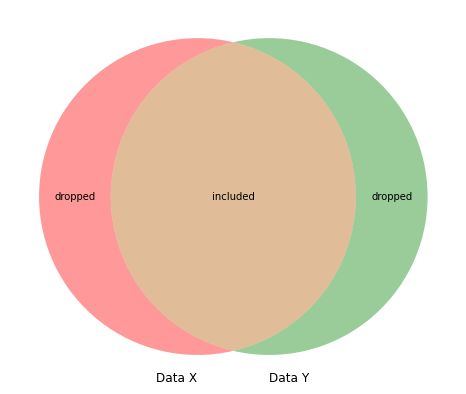

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

In [72]:
join = pd.merge(house, ap, on='County', how='left')
join.head(10)


,County,house1992,house1993,house1994,house1995,house1996,house1997,house1998,house1999,house2000,...,ap2013,ap2014,ap2015,ap2016,ap2017,ap2018,ap2019,ap2020,ap2021,ap2022
0,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
1,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
2,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
3,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,607,679,700,875,898,657,809,895,1274,948
4,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383
5,Landsdel Vest- og Sydsjælland,445,457,490,517,567,616,675,732,795,...,906,958,999,1058,1076,1087,1133,1179,1268,1259
6,Landsdel Fyn,470,477,523,555,639,686,785,816,860,...,1149,1198,1354,1340,1438,1585,1651,1750,1757,1770
7,Landsdel Sydjylland,494,508,559,583,664,704,754,810,852,...,1089,1083,1191,1177,1231,1366,1450,1407,1546,1506
8,Landsdel Østjylland,557,564,626,662,774,820,910,971,1035,...,1582,1690,1791,1825,1973,2017,2145,2272,2476,2363
9,Landsdel Vestjylland,471,483,530,558,617,646,699,737,767,...,1069,1017,1065,1047,1127,1152,1168,1137,1259,1221


In [73]:
join = join.melt(id_vars=['County'], var_name = 'Year', value_name='Sales')
join.head(10) 

,County,Year,Sales
0,Landsdel Byen København,house1992,767
1,Landsdel Københavns omegn,house1992,836
2,Landsdel Nordsjælland,house1992,797
3,Landsdel Bornholm,house1992,335
4,Landsdel Østsjælland,house1992,704
5,Landsdel Vest- og Sydsjælland,house1992,445
6,Landsdel Fyn,house1992,470
7,Landsdel Sydjylland,house1992,494
8,Landsdel Østjylland,house1992,557
9,Landsdel Vestjylland,house1992,471


In [ ]:
I = (outer.year.isin(diff_y)) | (outer.municipality.isin(diff_m))
outer.loc[I, :].head(15)

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.